# **Neural Network trained on Custom Recorded Dataset**

Trained a note classifier model using custom recorder dataset for all possible single notes in the fret broard from fret 1 to 4. Predict the notes for an audio by performing onsset detection to split the it into chunks and then classify the notes. The time gap between the detected notes is binned to whole inntegers corresponding second to capture temporal information.
Locally: `dataset`/`Kaggle Dataset`

### Training
- Onset detection is performed on each datapoint collected dataset, chunked to ensure silent audio parts are removed.
- The chunks are padded or trimmed to required shape.
- Mel-Frequency Cepstral Coefficients (MFCCs) are calculated for each chunk and fed to the model
- A neural network with 5 Dense layers and Leaky Relu is trained to predict the class (Note: due to small dataset, train dataset is used for both train test and val )

### Prediction
- Onset detection is performed an audio file to split it into chunks. Time gap between onset is binned based on ratio into integers.
- Chunks are padded with 0 or trimmed, then Mel-Frequency Cepstral Coefficients (MFCCs) are calculated for each chunk and fed to the model
- Model predicts notes for each set of MFCC
- Predicted class is decoded from the model output and shown for each note.
- Result is two list one for notes and another for the ratio of timegap between the notes being played

### Conclusion
The result are very close to the expected notes when testing on completely new data that is within the 0-4 fret range and is monophonic(single note). However dataset need to be expanded and more extensive testing can cause the model to break.
### Future improvements
An approach to use frequency-domain information directly with a CNN could lead to better results as information might be lost while performing MFCC. Increasing dataset could improve the results.


# **Building Note Classifier**

## Importing Libraries


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.layers import LeakyReLU

## Importing Note Files

In [ ]:
# Directory for single note guitar recordings(ranges only till 4rth fret) in the mounted drive
folder_path_notes = '/datasets/Custom Recorded - Notes(single,0-4)'


# Storing directory of these files in a list
wav_files = os.listdir(folder_path_notes)

# Checking number of files in list
print(len(wav_files))

Mounted at /content/drive
30 3


## Extracting Note Labels

In [ ]:
# Retrieving note labels from file name of each note recordings
label_list=[]
for file_name in wav_files:
  label_list.append(file_name[-6:-4])

#Checking note labels
print(label_list)

['51', '21', '50', '22', '53', '20', '52', '32', '34', '54', '33', '62', '10', '61', '11', '41', '42', '23', '40', '60', '44', '14', '63', '43', '30', '64', '13', '12', '24', '31']


## Creating Dataset (X and y)

In [ ]:
# Initialize an empty list to store data points
X = []
y = []

# Setting fixed duration for each note in dataset
desired_duration=1.5

# Loop that accesses files in wav_files and stores process audio data in X and note labels in y
for file_name in wav_files:

  # Retrieving file from directory
  file_path = os.path.join(folder_path_notes, file_name)

  # Loading audio file using librosa
  audio, sr = librosa.load(file_path, sr=None)

  # Find onsets,i.e, where the note starts
  onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
  onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

  # Convert frames to samples
  onsets_samples = librosa.frames_to_samples(onsets)

  # Finetuning the offset selection to get desired result
  if audio[onsets_samples[0]]<0.02 and audio[onsets_samples[0]]>-0.02:
    onsets_sample = onsets_samples[1]
  else:
    onsets_sample = onsets_samples[0]

  # Checking onset values to finetune
  # print(file_name,onsets_samples, 'value first onset: ' ,audio[onsets_samples[0]],'value second onset: ',audio[onsets_samples[0]+1])

  # Display waveform with onsets
  # plt.figure(figsize=(14, 5))
  # librosa.display.waveshow(audio, sr=sr, alpha=0.5)  # Display the waveform
  # plt.vlines(librosa.samples_to_time(onsets_sample, sr=sr), ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')  # Mark onsets with red dashed lines
  # plt.legend()
  # plt.show()

  # Cropping audio according to onset
  audio = audio[onsets_sample:]

  # If audio is shorter than desired duration, pad it with zeros to reach desired duration
  if len(audio) < desired_duration * sr:
    pad_length = int((desired_duration * sr) - len(audio))
    audio = np.pad(audio, (0, pad_length), mode='constant')

  # Else if audio is longer than desired duration, trim it to desired duration
  elif len(audio) > desired_duration * sr:
    audio = audio[:int(desired_duration * sr)]

  # Extract MFCC features from audio
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc= 100)

  # Flatten MFCC features and add to X
  X.append(mfccs.flatten())

  # Add note label to y
  y.append(file_name[-6:-4])


## Encoding Note Labels



In [ ]:
# Create and fit the label binarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(label_list)

# Transform the labels to binary format
y = label_binarizer.transform(y)

# Check the number of classes
num_classes = y.shape[1]
print("Number of classes:", num_classes)


Number of classes: 30


In [ ]:
# Converting X to numpy array
X=np.array(X)

## Train Test Val Split



The test and validation data are a subset of the training data itself here as there are only 30 datapoints, one for each note.<br>
This dataset is currently being expanded.

In [ ]:
# Train Test Val Split (80-20)
_,X_val,_,y_val=train_test_split(X,y,test_size=0.2,random_state=10)
_,X_test,_,y_test=train_test_split(X,y,test_size=0.2,random_state=20)

## Note Classification Model

In [ ]:
# No of classes
num_labels=y.shape[1]

# Define the model2
model = Sequential([
    Flatten(input_shape=(X.shape[1],)),  # Flatten the input audio array
    Dense(1280),
    LeakyReLU(alpha=0.1),
    Dense(1280),
    LeakyReLU(alpha=0.1),
    Dense(1280),
    LeakyReLU(alpha=0.1),
    Dense(1280),
    LeakyReLU(alpha=0.1),
    Dense(1280),
    LeakyReLU(alpha=0.1),
    Dense(num_labels, activation='softmax')  # Output layer with 10 units (assuming 10 labels) and softmax activation
])


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

In [ ]:
# Training the model
num_epochs = 100
num_batch_size = 10

model.fit(X, y, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
3/3 [==============================] - 3s 625ms/step - loss: 178.6719 - accuracy: 0.0000e+00 - val_loss: 157.7967 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 1s 465ms/step - loss: 180.3135 - accuracy: 0.0333 - val_loss: 209.1129 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 1s 463ms/step - loss: 296.6474 - accuracy: 0.0667 - val_loss: 81.2351 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 1s 490ms/step - loss: 212.5245 - accuracy: 0.1000 - val_loss: 46.5986 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 1s 450ms/step - loss: 200.0743 - accuracy: 0.1000 - val_loss: 52.9626 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 2s 677ms/step - loss: 90.5952 - accuracy: 0.0333 - val_loss: 22.4981 - val_accuracy: 0.3333
Epoch 7/100
3/3 [==============================] - 2s 698ms/step - loss: 61.9916 - accuracy: 0.2333 - val_loss:

## Evaluate the Model

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 51ms/step - loss: 86.5844 - accuracy: 0.6667
Accuracy: 0.6666666865348816


# **Predicting notes on continuous music data after onset detection**

## Importing Libraries

In [ ]:
from scipy.io.wavfile import write
from IPython.display import Audio

## Creating Test Data

In [ ]:
# # Creating normal music data with multiple notes artificially

# # Choosing notes to create Test data
# c_chord_audio=[wav_files[4],wav_files[16],wav_files[24],wav_files[1],wav_files[24],wav_files[16],wav_files[4],wav_files[16],wav_files[24],wav_files[1],wav_files[24],wav_files[16]]

# # Randomly sampling 10 files
# # selected_files = random.sample(wav_files, 10)

# # Using chosen files
# selected_files = c_chord_audio

# # Initializing array of audio_data to be predicted
# audio_data = np.array([])

# # Loop that accesses files and adds to audio_data
# for file_name in selected_files:

#     # Retrieving file from directory
#     file_path = os.path.join(folder_path_notes, file_name)

#     # Loading audio file using librosa
#     audio, sr = librosa.load(file_path, sr=None)

#     # If audio is shorter than desired duration, pad it with zeros
#     if len(audio) < desired_duration * sr:
#         pad_length = int((desired_duration * sr) - len(audio))
#         audio = np.pad(audio, (0, pad_length), mode='constant')
#     # If audio is longer than desired duration, trim it
#     elif len(audio) > desired_duration * sr:
#         audio = audio[:int(desired_duration * sr)]

#     # Shorten audio data to create random variations in each note (1 reffers 0.25 sec duration and 6 reffers to 1.5sec duration)
#     # shorten_factor = random.randint(1, 6)
#     shorten_factor = 4
#     audio = audio[:int((sr/4)*shorten_factor)]

#     # Concatenate audio to form audio data point
#     audio_data = np.concatenate((audio_data,audio))

# # Renaming audio_data as test
# test=audio_data


## Importing Test Data

In [ ]:
# Loading test_audio1 from test_audio_files using Librosa
file_path = os.path.join(folder_path_test, 'c-chord.wav')
test, sr = librosa.load(file_path, sr=None)

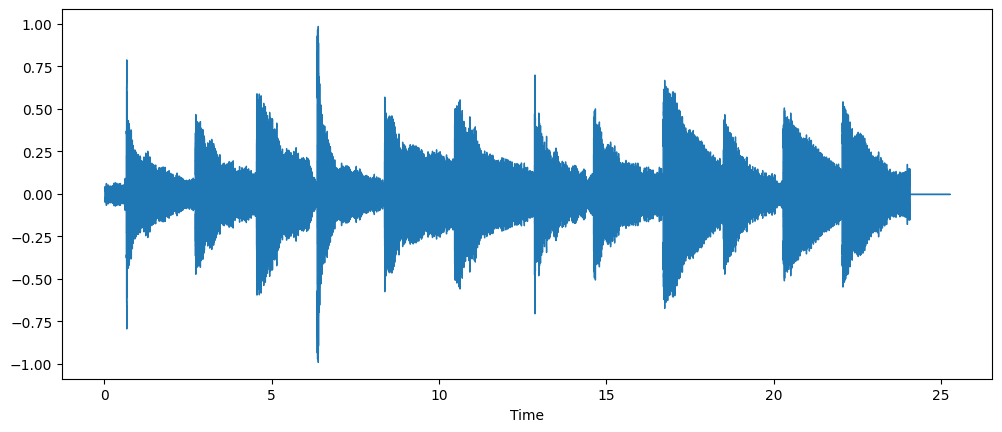

In [ ]:
# Plotting test data
plt.figure().set_figwidth(12)
librosa.display.waveshow(test, sr=sr)

## Listening to Test Data

In [ ]:
# Assuming sr is the sampling rate of the audio
sr = 44100

# Normalize test to the range [-32768, 32767] for 16-bit PCM format
audio_data_normalized = np.int16(test * 32767)

# Save test to a WAV file
write('output.wav', sr, audio_data_normalized)

# Load and play the saved audio file
Audio('output.wav', autoplay=True)

## Onset Detection

In [ ]:
# Detect note onsets
onset_env = librosa.onset.onset_strength(y=test, sr=sr)
onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

# Convert frames to samples
arr = librosa.frames_to_samples(onsets)

#Checking the detected onsets
print(arr)

# Finetuning the onsets to handle error
i = 0
while i < len(arr) - 1:
    if arr[i+1] - arr[i] < 11025:
        if arr[i] < arr[i+1]:
            arr = np.delete(arr, i)
        else:
            arr = np.delete(arr, i+1)
    else:
        i += 1

# Checking the finetuned onsets
print(arr)

[   1536   28672  119808  200192  280064  369152  461312  566784  644096
  736256  815616  893952  971776 1056256 1061888]
[   1536   28672  119808  200192  280064  369152  461312  566784  644096
  736256  815616  893952  971776 1061888]


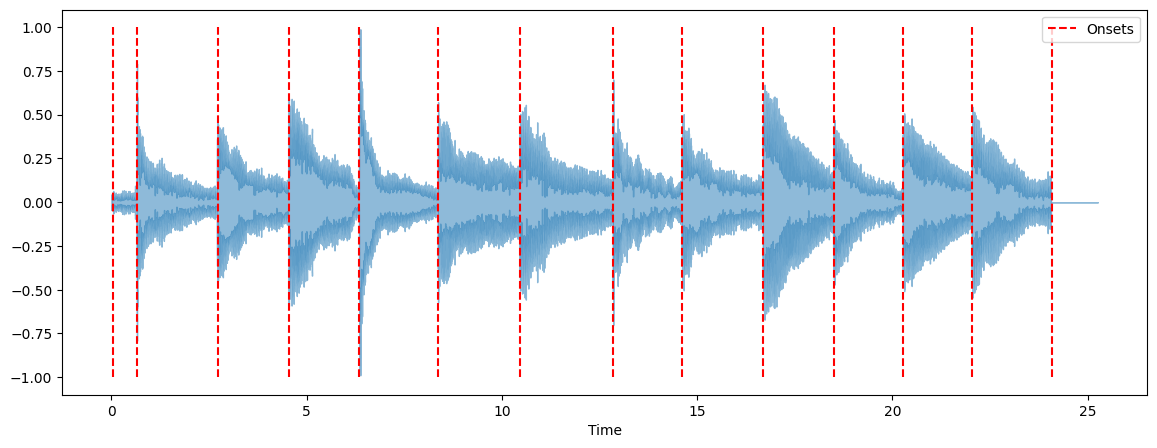

In [ ]:
# Display waveform with onsets
plt.figure(figsize=(14, 5))
librosa.display.waveshow(test, sr=sr, alpha=0.5)  # Display the waveform
plt.vlines(librosa.samples_to_time(arr, sr=sr), ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')  # Mark onsets with red dashed lines
plt.legend()
plt.show()

## Extracting features for detected notes

In [ ]:
# Initialize features
features = []

# Loop all the values in onsets
for i in range(0,len(arr)):

    # Setting start of note
    onset = arr[i]

    # Setting end of note and Slicing test for note segment (handling edge case of last note no having end)
    if(i!=len(arr)-1):
      next_onset = arr[i + 1]
      note_segment = test[onset:next_onset]
    else:
      note_segment = test[onset:]

    # Converting to numpy array
    note_segment = np.array(note_segment)

    # Padding note_segment to desired duration
    if len(note_segment)<1.5*sr:
      pad_length = int(1.5 * sr) - len(note_segment)
      note_segment = np.pad(note_segment, (0, pad_length), mode='constant')
    elif len(note_segment)>1.5*sr:
      note_segment = note_segment[:int(1.5 * sr)]

    # Extracting MFCCs features from note segment
    mfccs = librosa.feature.mfcc(y=note_segment, sr=sr, n_mfcc= 100)
    features.append(mfccs.flatten())

# Converting features to numpy array
features=np.array(features)

## Predicting Notes using trained Model

In [ ]:
# Predict the notes using the model
predictions = model.predict(features)

# Find the index of the maximum value in each array
max_indices = np.argmax(predictions, axis=1)

# Create a new array with the same shape as predictions
binary_predictions = np.zeros_like(predictions)

# Set the maximum value in each array to 1
binary_predictions[np.arange(len(predictions)), max_indices] = 1

# Inverse transform the labels
decoded_labels = label_binarizer.inverse_transform(predictions)

# Print predicted notes
print("Predicted Notes: ",decoded_labels)

1/1 [==============================] - 0s 471ms/step
Predicted Notes:  ['51' '51' '51' '42' '24' '64' '23' '51' '23' '42' '44' '64' '23' '51']


## Time Gap Calculation between Notes

In [ ]:
# Calculate the time gaps between notes, convert to seconds
time_gaps = np.diff(arr) / sr

time_gaps = np.append((test.shape[0]-arr[-1])/sr,time_gaps)


## Predicted Result

In [ ]:
# Return the result as a numpy array on note and timegap
result = np.column_stack((decoded_labels, time_gaps))

In [ ]:
# Display final result
print(result)

[['51' '1.1812244897959183']
 ['51' '0.615328798185941']
 ['51' '2.066575963718821']
 ['42' '1.822766439909297']
 ['24' '1.811156462585034']
 ['64' '2.020136054421769']
 ['23' '2.089795918367347']
 ['51' '2.391655328798186']
 ['23' '1.7531065759637188']
 ['42' '2.089795918367347']
 ['44' '1.799546485260771']
 ['64' '1.7763265306122449']
 ['23' '1.7647165532879818']
 ['51' '2.043356009070295']]


# **Conclusion**


The result are very close to the expected notes when testing on completely new data that is within the 0-4 fret range and is monophonic(single note). However dataset need to be expanded and more extensive testing can cause the model to break.

An approach to use frequency-domain information directly with a CNN could lead to better results as information might be lost while performing MFCC. Increasing dataset could improve the results.
